# 迁移学习
主要参考于[DeepLearning.ai课程](https://github.com/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%206%20-%20Lesson%203%20-%20Notebook.ipynb)

**迁移学习：**有现存的已经在很多数据上训练过的模型，从运用这些模型从中学习到特征，用于自己的项目。

通过获得已经训练好的神经网络模型和参数，并且重新训练全连接层，即可以用来解决其他实际问题

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# 使用keras内置的InceptionV3模型
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                # 初始化的V3在第一层具有一个全连接层，
                                # 使用include_top=False将其忽略
                                # 直接进入卷积层
                               include_top=False,
                               # 表示不需要内置建立权重 
                               weights = None)


pre_trained_model.load_weights(local_weights_file)

# 遍历模型并且设置为：这些层次将不用于训练权重，而是采用之前加载的权重
for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

# 为了获得更多的特征，选择mixed7作为卷积层的最后一层
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [9]:
from tensorflow.keras.optimizers import RMSprop

# 定义一个新的模型
# 展平last_output
x = layers.Flatten()(last_output)
# 添加一层全连接层
x = layers.Dense(1024,activation='relu')(x)
# 添加一层Dropout层
# 防止过拟合
x = layers.Dropout(0.2)(x)

# 最后一层
x = layers.Dense(1,activation='sigmoid')(x)

# 使用Model类创建模型：传递之前创建的输入和图层定义
model = Model(pre_trained_model.input,x)

# 编译模型：
model.compile(optimizer = RMSprop(lr=0.0001),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [10]:
# 生成训练数据的生成器
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = 'tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('tmp')
zip_ref.close()

base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs') 
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# 在生成器中添加数据扩增的参数
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# 验证集不应该使用数据扩增
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# 以20的批大小输出的图片生成器
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# 训练模型

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,# 2000 / 100 =100
            epochs = 20,
            validation_steps = 50,
            verbose = 2)



  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 - 299s - loss: 0.5282 - accuracy: 0.7545 - val_loss: 0.4792 - val_accuracy: 0.8700
Epoch 2/20
100/100 - 323s - loss: 0.3744 - accuracy: 0.8315 - val_loss: 0.3777 - val_accuracy: 0.9190
Epoch 3/20
100/100 - 291s - loss: 0.3448 - accuracy: 0.8495 - val_loss: 0.3161 - val_accuracy: 0.9360
Epoch 4/20
100/100 - 281s - loss: 0.3287 - accuracy: 0.8590 - val_loss: 0.4631 - val_accuracy: 0.9240
Epoch 5/20
100/100 - 277s - loss: 0.3346 - accuracy: 0.8565 - val_loss: 0.2584 - val_accuracy: 0.9590
Epoch 6/20
100/100 - 263s - loss: 0.3048 - accuracy: 0.8705 - val_loss: 0.2982 - val_accuracy: 0.9560
Epoch 7/20
100/100 - 227s - loss: 0.2931 - accuracy: 0.8790 - val_loss: 0.2676 - val_accuracy: 0.9670
Epoch 8/20
100/100 - 239s - loss: 0.2873 - accuracy: 0.8740 - val_loss: 0.4323 - val_accuracy: 0.9500
Epoch 9/20
100/100 - 228s - loss: 0.2823 - accuracy: 0.8825 - val_loss: 0.4696 - val_accura

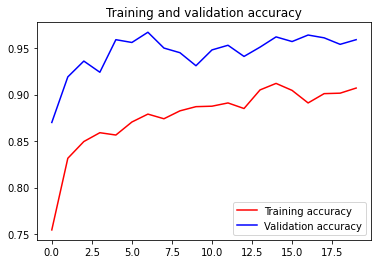

<Figure size 432x288 with 0 Axes>

In [12]:
# 可视化精确度和损失
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()